In [ ]:
# Core
import os, math, random, time, warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

# Scientific
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision import transforms as T

# Visualization
import matplotlib.pyplot as plt

# PIL for occlusions
from PIL import Image, ImageDraw, ImageFilter

warnings.filterwarnings("ignore")

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
@dataclass
class Config:
    image_size: int = 64
    num_classes: int = 5
    train_per_class: int = 600
    val_per_class: int = 150
    test_per_class: int = 200
    batch_size: int = 64
    epochs: int = 3
    lr: float = 1e-3
    weight_decay: float = 1e-4
    num_workers: int = 2
    data_root: str = "./data"
    seed: int = 42

    # Occlusion settings
    occlusion_levels: List[float] = (0.10, 0.30, 0.50)
    occlusion_types: List[str] = ("rectangle", "stripes", "cutout", "blur_patch", "noise_patch")

cfg = Config()

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = T.Compose([
    T.RandomResizedCrop(cfg.image_size, scale=(0.85, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = T.Compose([
    T.Resize((cfg.image_size, cfg.image_size)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [ ]:
# Helper to get labels/targets array from a torchvision dataset (robust across torchvision versions)
def get_targets(ds):
    for attr in ["targets", "labels"]:
        if hasattr(ds, attr):
            arr = getattr(ds, attr)
            try:
                import torch as _torch
                if isinstance(arr, _torch.Tensor):
                    arr = arr.cpu().numpy()
            except Exception:
                pass
            return np.array(arr)
    for attr in ["samples", "imgs"]:
        if hasattr(ds, attr):
            return np.array([y for _, y in getattr(ds, attr)])
    # Fallback: one pass (ok since transform=None here)
    labels = []
    for _, y in ds:
        labels.append(int(y))
    return np.array(labels)

# Build balanced subsets by top-K frequent classes (returns top_classes, class_map, and indices)
def build_balanced_indices(targets: np.ndarray, num_classes: int):
    class_counts = {c: (targets == c).sum() for c in np.unique(targets)}
    top_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:num_classes]
    class_map = {c: i for i, c in enumerate(top_classes)}
    print("Selected classes:", top_classes)
    print("Class remapping:", class_map)

    rng = np.random.RandomState(cfg.seed)
    train_idx, val_idx = [], []
    for c in top_classes:
        idx_c = np.where(targets == c)[0]
        rng.shuffle(idx_c)
        take_train = min(cfg.train_per_class, len(idx_c))
        take_val   = min(cfg.val_per_class, max(0, len(idx_c) - take_train))
        train_idx.extend(idx_c[:take_train])
        val_idx.extend(idx_c[take_train:take_train + take_val])
    return top_classes, class_map, train_idx, val_idx

# Dataset wrapper that applies transforms and remaps labels to 0..num_classes-1
from torch.utils.data import Dataset, DataLoader

class TransformedSubset(Dataset):
    def __init__(self, base_ds, indices, transform, class_map=None):
        self.base = base_ds
        self.indices = list(indices)
        self.transform = transform
        self.class_map = class_map

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.base[self.indices[i]]
        if self.transform is not None:
            img = self.transform(img)
        y = int(label)
        if self.class_map is not None:
            y = self.class_map[y]
        return img, y

# Download once (train + test)
ds_train_raw = datasets.GTSRB(root=cfg.data_root, split='train', download=True, transform=None)
ds_test_raw  = datasets.GTSRB(root=cfg.data_root, split='test',  download=True, transform=None)

# Create balanced train/val indices from training split
targets_train = get_targets(ds_train_raw)
top_classes, class_map, train_idx, val_idx = build_balanced_indices(targets_train, cfg.num_classes)

# For test: balanced sampling from the test split among the same selected classes
targets_test = get_targets(ds_test_raw)
rng = np.random.RandomState(cfg.seed + 1)
test_idx = []
for c in top_classes:
    idx_c = np.where(targets_test == c)[0]
    rng.shuffle(idx_c)
    take = min(cfg.test_per_class, len(idx_c))
    test_idx.extend(idx_c[:take])

# Final datasets with transforms AND remapped labels
train_ds = TransformedSubset(ds_train_raw, train_idx, train_tfms, class_map=class_map)
val_ds   = TransformedSubset(ds_train_raw, val_idx,   test_tfms,  class_map=class_map)
test_ds  = TransformedSubset(ds_test_raw,  test_idx,  test_tfms,  class_map=class_map)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

Selected classes: [np.int64(1), np.int64(2), np.int64(13), np.int64(12), np.int64(38)]
Class remapping: {np.int64(1): 0, np.int64(2): 1, np.int64(13): 2, np.int64(12): 3, np.int64(38): 4}


(3000, 750, 1000)

In [ ]:
def create_model(num_classes: int):
    try:
        weights = models.ResNet18_Weights.DEFAULT
        backbone = models.resnet18(weights=weights)
    except Exception:
        # Fallback for older torchvision
        backbone = models.resnet18(pretrained=True)
    # Freeze backbone for a quick demo fine-tune
    for p in backbone.parameters():
        p.requires_grad = False
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, num_classes)
    return backbone

def accuracy(preds: torch.Tensor, targets: torch.Tensor) -> float:
    return (preds.argmax(dim=1) == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader) -> Dict[str, float]:
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    probs = logits.softmax(dim=1)
    conf, preds = probs.max(dim=1)
    return {
        "acc": (preds == targets).float().mean().item(),
        "mean_conf": conf.mean().item(),
        "logits": logits,
        "targets": targets
    }

def train(model, train_loader, val_loader, epochs=cfg.epochs, lr=cfg.lr, weight_decay=cfg.weight_decay):
    model = model.to(device)
    opt = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    best_val = -1.0
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        ep_loss, ep_acc, n_batches = 0.0, 0.0, 0
        t0 = time.time()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).long()
            # Defensive check: targets must be in [0, C-1]
            assert y.min().item() >= 0 and y.max().item() < model.fc.out_features, \
                f"Target out of range in batch: [{int(y.min())}, {int(y.max())}] vs C={model.fc.out_features}"

            logits = model(x)
            loss = criterion(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            with torch.no_grad():
                ep_loss += loss.item()
                ep_acc += accuracy(logits, y)
                n_batches += 1

        val_metrics = evaluate(model, val_loader)
        if val_metrics["acc"] > best_val:
            best_val = val_metrics["acc"]
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"Epoch {ep:02d} | train_loss={ep_loss/n_batches:.4f} train_acc={ep_acc/n_batches:.3f} "
              f"| val_acc={val_metrics['acc']:.3f} | time={(time.time()-t0):.1f}s")

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
    return model

In [ ]:
# Sanity checks (run this just before training)
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # clearer error messages on GPU

print("cfg.num_classes =", cfg.num_classes)
print("Lengths: train/val/test =", len(train_ds), len(val_ds), len(test_ds))

xb, yb = next(iter(train_loader))
print("Batch y min/max =", int(yb.min()), int(yb.max()), "| dtype =", yb.dtype)
assert yb.min().item() >= 0 and yb.max().item() < cfg.num_classes, \
    f"Targets out of range: [{int(yb.min())}, {int(yb.max())}] for num_classes={cfg.num_classes}"

tmp_model = create_model(num_classes=cfg.num_classes)
print("Model head out_features =", tmp_model.fc.out_features)
assert tmp_model.fc.out_features == cfg.num_classes, "Model head/output size mismatch"

cfg.num_classes = 5
Lengths: train/val/test = 3000 750 1000
Batch y min/max = 0 4 | dtype = torch.int64
Model head out_features = 5


In [ ]:
model = create_model(num_classes=cfg.num_classes)
model = train(model, train_loader, val_loader, epochs=cfg.epochs, lr=cfg.lr, weight_decay=cfg.weight_decay)

clean_test_metrics = evaluate(model, test_loader)
print({k: float(v) if isinstance(v, (int, float)) else None for k,v in clean_test_metrics.items() if k in ["acc","mean_conf"]})

Epoch 01 | train_loss=1.0109 train_acc=0.605 | val_acc=0.795 | time=4.4s
Epoch 02 | train_loss=0.5378 train_acc=0.815 | val_acc=0.843 | time=4.2s
Epoch 03 | train_loss=0.4431 train_acc=0.847 | val_acc=0.855 | time=4.3s
{'acc': 0.8080000281333923, 'mean_conf': 0.7561882734298706}


In [ ]:
# Occlusion primitives (PIL-based)
def occlude_pil(img: Image.Image, occl_type: str, level: float, rng: random.Random) -> Image.Image:
    w, h = img.size
    area = w * h
    img = img.copy()

    if occl_type in ("rectangle", "cutout", "blur_patch", "noise_patch"):
        A = max(1, int(level * area))
        side = int(max(1, min(int(math.sqrt(A)), min(w, h) - 1)))
        x0 = rng.randint(0, max(0, w - side))
        y0 = rng.randint(0, max(0, h - side))
        box = (x0, y0, x0 + side, y0 + side)

        if occl_type == "rectangle":
            draw = ImageDraw.Draw(img)
            draw.rectangle(box, fill=(0, 0, 0))

        elif occl_type == "cutout":
            draw = ImageDraw.Draw(img)
            draw.rectangle(box, fill=(127, 127, 127))

        elif occl_type == "blur_patch":
            patch = img.crop(box).filter(ImageFilter.GaussianBlur(radius=max(1, side // 10)))
            img.paste(patch, box)

        elif occl_type == "noise_patch":
            patch = Image.fromarray(
                np.uint8(np.clip(np.random.normal(loc=127, scale=60, size=(side, side, 3)), 0, 255))
            )
            img.paste(patch, box)

    elif occl_type == "stripes":
        draw = ImageDraw.Draw(img)
        stripe_width = max(1, int(w * 0.05))
        n_stripes = max(1, int(level * (w * h) / (stripe_width * h)))
        positions = [rng.randint(0, max(0, w - stripe_width)) for _ in range(n_stripes)]
        for x in positions:
            draw.rectangle((x, 0, x + stripe_width, h), fill=(0, 0, 0))
    else:
        raise ValueError(f"Unknown occlusion type: {occl_type}")

    return img

# Occluded dataset wrapper (remaps labels with class_map)
class OccludedSubset(Dataset):
    def __init__(self, base_ds, indices, transform, occlusion_type: str, occlusion_level: float, seed: int, class_map=None):
        self.base = base_ds
        self.indices = list(indices)
        self.transform = transform
        self.occlusion_type = occlusion_type
        self.occlusion_level = float(occlusion_level)
        self.rng = random.Random(seed)
        self.class_map = class_map

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.base[self.indices[i]]
        img = occlude_pil(img, self.occlusion_type, self.occlusion_level, self.rng)
        if self.transform is not None:
            img = self.transform(img)
        y = int(label)
        if self.class_map is not None:
            y = self.class_map[y]
        meta = {"occlusion_type": self.occlusion_type, "occlusion_level": self.occlusion_level}
        return img, y, meta

# Quick visual sanity check helper
def show_examples(dataset, n=6):
    plt.figure(figsize=(12, 2.5))
    for i in range(n):
        sample = dataset[i]
        img_t = sample[0]
        if isinstance(img_t, torch.Tensor):
            img_np = img_t.cpu().permute(1,2,0).numpy()
            img_np = (img_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0,1)
        else:
            img_np = np.array(img_t)
        plt.subplot(1, n, i+1)
        plt.imshow(img_np)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
@torch.no_grad()
def evaluate_with_optional_meta(model, loader, has_meta=False):
    model.eval()
    all_logits, all_targets, all_meta = [], [], []
    for batch in loader:
        if has_meta:
            x, y, meta = batch
        else:
            x, y = batch
            meta = None
        x, y = x.to(device), y.to(device)
        logits = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
        if meta is not None:
            all_meta.extend(meta)
    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    probs = logits.softmax(dim=1)
    conf, preds = probs.max(dim=1)
    metrics = {
        "acc": (preds == targets).float().mean().item(),
        "mean_conf": conf.mean().item(),
        "logits": logits,
        "targets": targets
    }
    if has_meta:
        metrics["meta"] = all_meta
    return metrics

# ECE (Expected Calibration Error) + bin stats
def compute_ece(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15):
    conf = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    correct = (preds == labels).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    bin_data = []
    N = len(labels)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (conf > lo) & (conf <= hi) if i > 0 else (conf >= lo) & (conf <= hi)
        if mask.sum() == 0:
            bin_data.append((0.0, 0.0, 0))
            continue
        acc_bin = correct[mask].mean()
        conf_bin = conf[mask].mean()
        w = mask.mean()
        ece += w * abs(acc_bin - conf_bin)
        bin_data.append((acc_bin, conf_bin, int(mask.sum())))
    return float(ece), bin_data

rectangle    lvl=0.10 | acc=0.529 | conf=0.696 | ECE=0.179
rectangle    lvl=0.30 | acc=0.343 | conf=0.659 | ECE=0.319
rectangle    lvl=0.50 | acc=0.224 | conf=0.636 | ECE=0.412
stripes      lvl=0.10 | acc=0.529 | conf=0.667 | ECE=0.138
stripes      lvl=0.30 | acc=0.367 | conf=0.602 | ECE=0.235
stripes      lvl=0.50 | acc=0.327 | conf=0.566 | ECE=0.239
cutout       lvl=0.10 | acc=0.654 | conf=0.731 | ECE=0.081
cutout       lvl=0.30 | acc=0.433 | conf=0.674 | ECE=0.243
cutout       lvl=0.50 | acc=0.262 | conf=0.621 | ECE=0.359
blur_patch   lvl=0.10 | acc=0.793 | conf=0.750 | ECE=0.051
blur_patch   lvl=0.30 | acc=0.654 | conf=0.696 | ECE=0.062
blur_patch   lvl=0.50 | acc=0.435 | conf=0.562 | ECE=0.128
noise_patch  lvl=0.10 | acc=0.633 | conf=0.706 | ECE=0.089
noise_patch  lvl=0.30 | acc=0.426 | conf=0.629 | ECE=0.203
noise_patch  lvl=0.50 | acc=0.276 | conf=0.560 | ECE=0.286


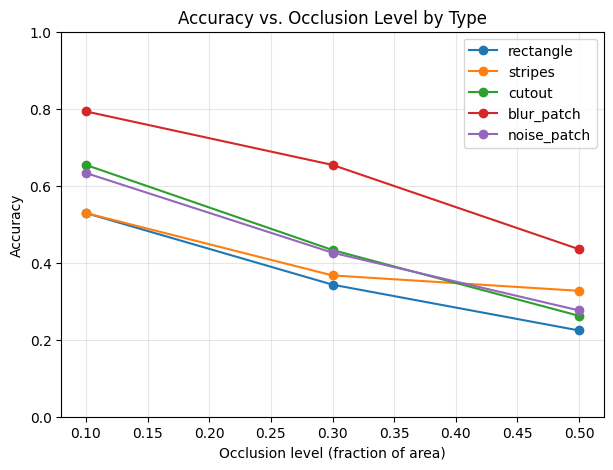

In [ ]:
# Sweep occlusion types and levels
results = []
for occl_type in cfg.occlusion_types:
    for lvl in cfg.occlusion_levels:
        occl_test_ds = OccludedSubset(ds_test_raw, test_idx, test_tfms, occl_type, lvl, seed=cfg.seed, class_map=class_map)
        occl_test_loader = DataLoader(occl_test_ds, batch_size=cfg.batch_size, shuffle=False,
                                      num_workers=cfg.num_workers, pin_memory=True)
        m = evaluate_with_optional_meta(model, occl_test_loader, has_meta=True)
        probs = m["logits"].softmax(dim=1).numpy()
        labels = m["targets"].numpy()
        ece, _ = compute_ece(probs, labels, n_bins=15)
        results.append({
            "type": occl_type,
            "level": float(lvl),
            "acc": float(m["acc"]),
            "mean_conf": float(m["mean_conf"]),
            "ece": ece
        })
        print(f"{occl_type:<12} lvl={lvl:.2f} | acc={m['acc']:.3f} | conf={m['mean_conf']:.3f} | ECE={ece:.3f}")

# Plot accuracy vs. occlusion level per type
plt.figure(figsize=(7,5))
for occl_type in cfg.occlusion_types:
    xs = [r["level"] for r in results if r["type"] == occl_type]
    ys = [r["acc"]   for r in results if r["type"] == occl_type]
    plt.plot(xs, ys, marker='o', label=occl_type)
plt.title("Accuracy vs. Occlusion Level by Type")
plt.xlabel("Occlusion level (fraction of area)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()